In [1]:
# install some requirement libraries
!pip install split-folders
!pip install torch-summary

In [2]:
# import requirement libraries and tools
import os
import pathlib
import numpy as np
import splitfolders
import itertools
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchsummary import summary

In [3]:
# dataset path
dataset_path = '/kaggle/input/rice-datasource/Rice_Image_Dataset'
dataset_path = pathlib.Path(dataset_path)
# Define the output directory where the split datasets will be saved
output_dir = 'rice_image_splits'

# Split the dataset into training, validation, and test sets
splitfolders.ratio(
    input=dataset_path,        
    output=output_dir,         
    seed=42,                   
    ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [08:48, 141.97 files/s]



Train Dataset:
Train Batch Shape: torch.Size([32, 3, 150, 150])
Train Labels: tensor([4, 0, 1, 4, 1, 3, 2, 0, 4, 1, 4, 3, 2, 1, 0, 0, 1, 2, 1, 4, 4, 0, 0, 2,
        3, 1, 0, 2, 3, 0, 1, 3])


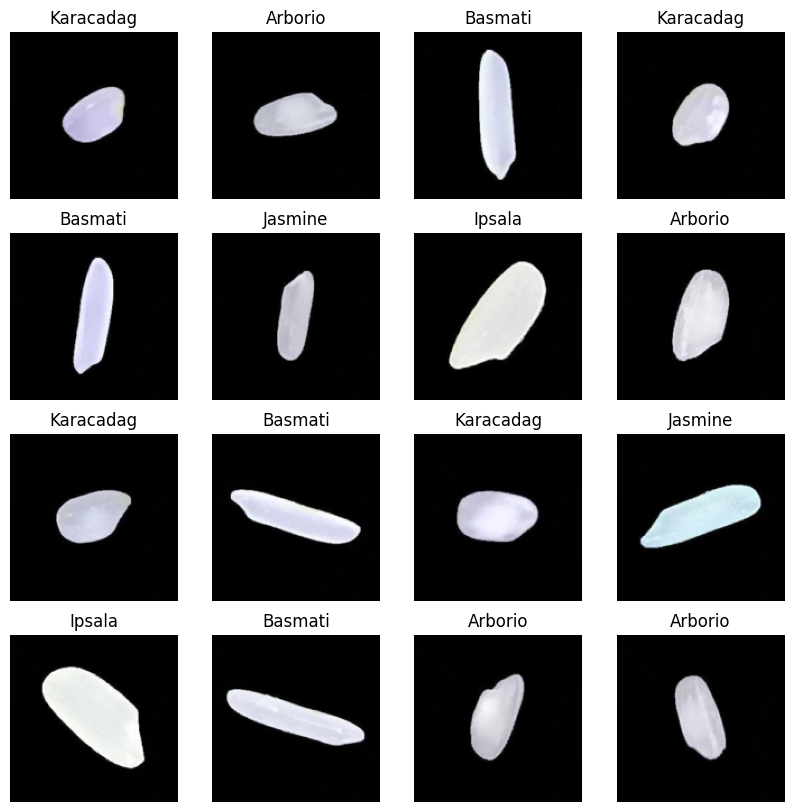


Validation Dataset:
Validation Batch Shape: torch.Size([32, 3, 150, 150])
Validation Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


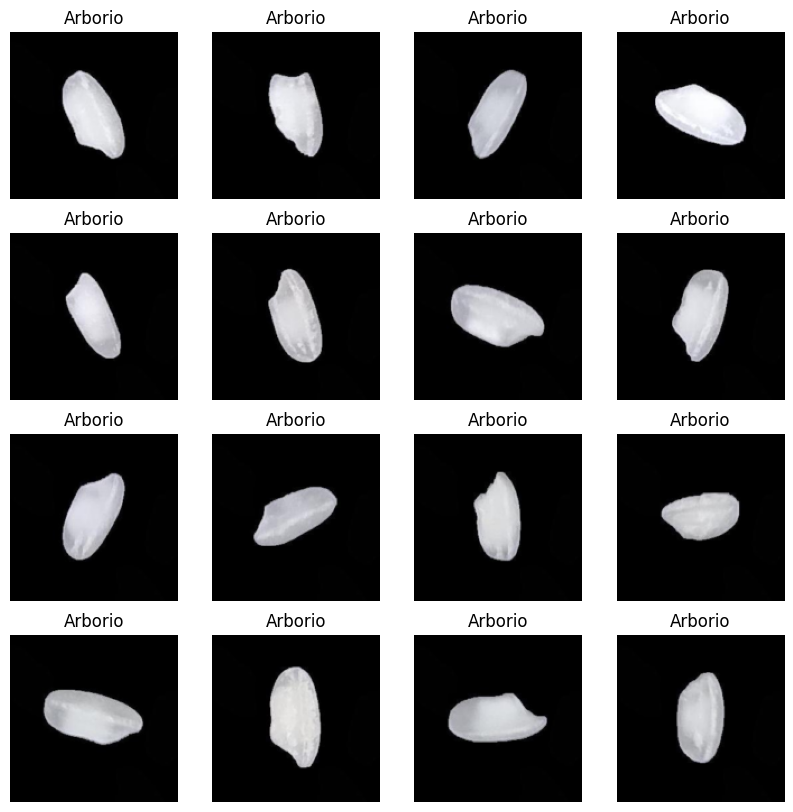


Test Dataset:
Test Batch Shape: torch.Size([32, 3, 150, 150])
Test Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


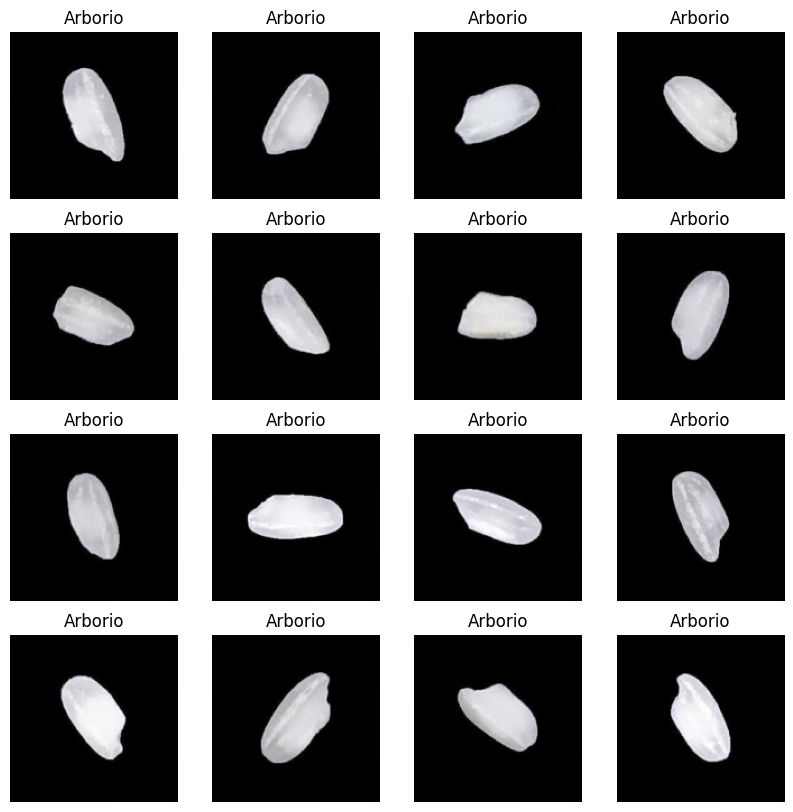

In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transformation for the dataset (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((150, 150)),   # Resize images to (150, 150)
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

# Define dataset paths
train_dir = 'rice_image_splits/train'
val_dir = 'rice_image_splits/val'
test_dir = 'rice_image_splits/test'

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define a mapping for class labels
labels_map = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"
}

# Function to show images in a grid
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize
        plt.title(labels_map[labels[i].item()])
        plt.axis("off")
    plt.show()

# Function to print batch info and visualize images
def show_batch_info(data_loader, dataset_name):
    print(f"\n{dataset_name} Dataset:")
    for images, labels in data_loader:
        print(f"{dataset_name} Batch Shape: {images.shape}")
        print(f"{dataset_name} Labels: {labels}")
        show_images(images[:16], labels[:16])
        break

show_batch_info(train_loader, "Train")
show_batch_info(val_loader, "Validation")
show_batch_info(test_loader, "Test")

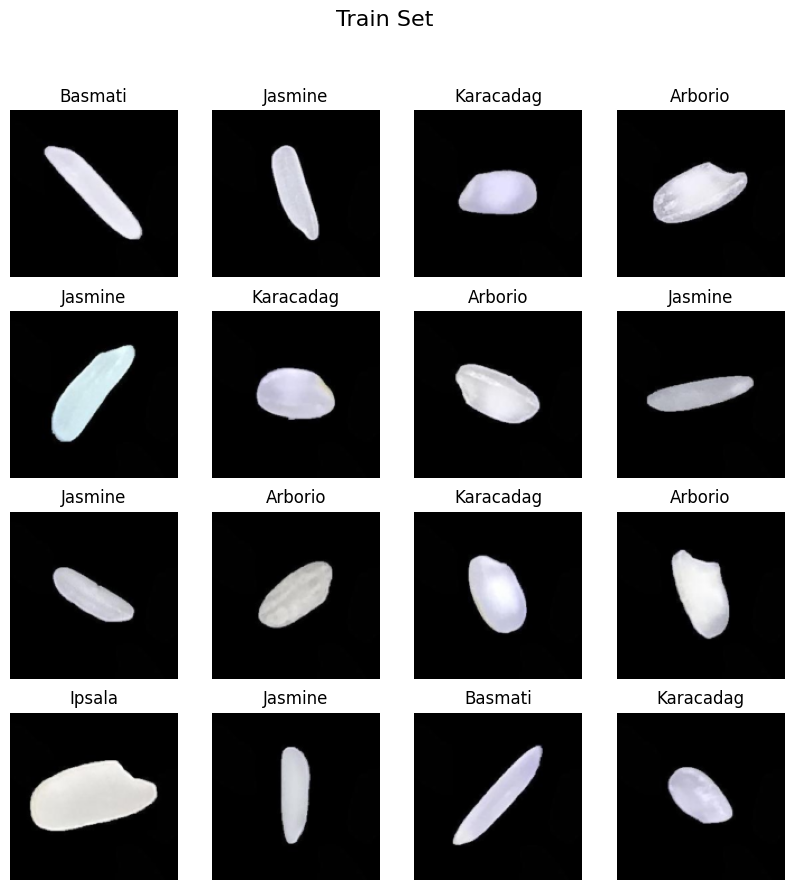

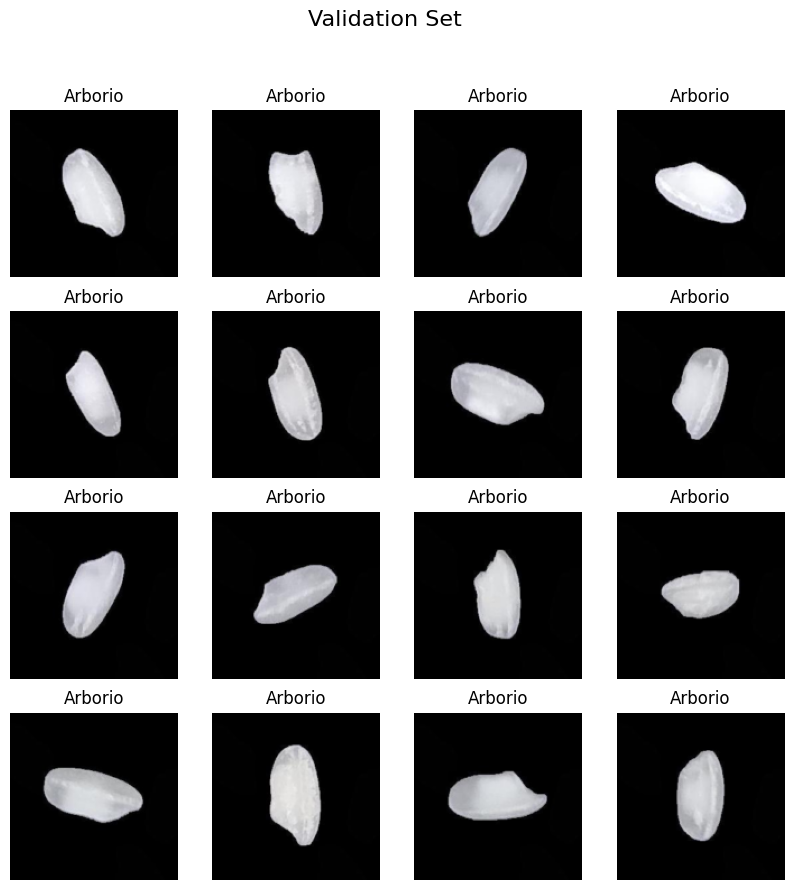

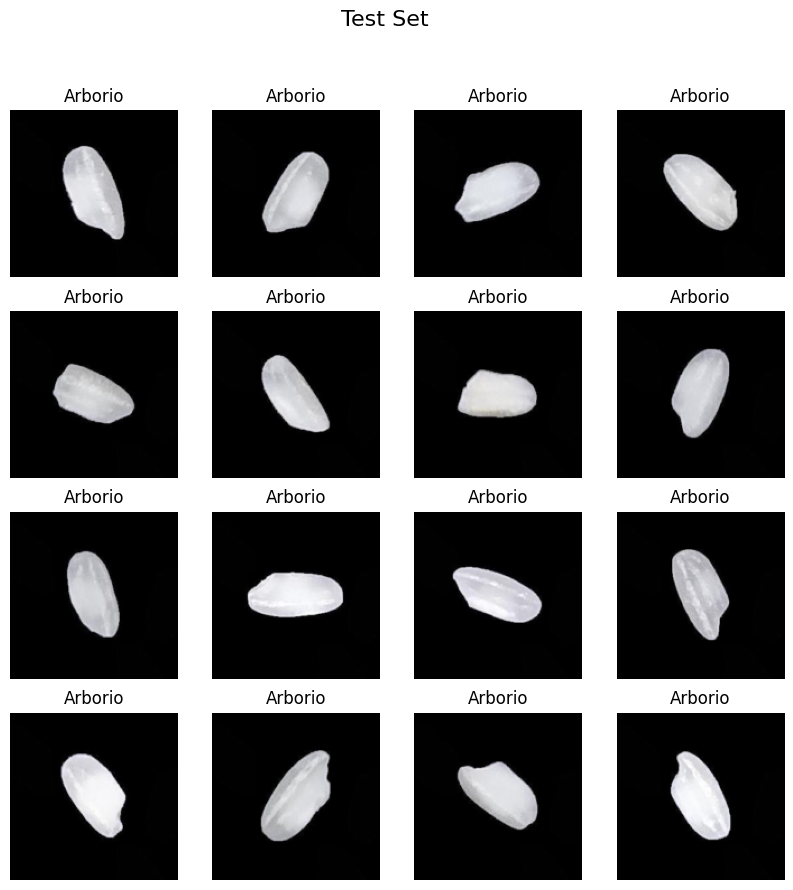

In [5]:
# Function to visualize a batch of images and labels
def visualize_batch(loader, title):
    data_iter = iter(loader)
    images, labels = next(data_iter)  # Corrected the call to next()
    
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize and show
        plt.title(labels_map[labels[i].item()])
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualize train, validation, and test sets
visualize_batch(train_loader, "Train Set")
visualize_batch(val_loader, "Validation Set")
visualize_batch(test_loader, "Test Set")

In [6]:
# Define the CNN Model with controlled shape printing
class CNNModel1(nn.Module):
    def __init__(self):
        super(CNNModel1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        self.fc1 = nn.Linear(16 * 75 * 75, 128)  
        self.fc2 = nn.Linear(128, 5)  
        self.shape_printed = False

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv + Relu + Pool
        
        # Print shape only once
        if not self.shape_printed:
            print(f"Shape after conv and pool: {x.shape}")
            self.shape_printed = True  # Ensure shape is printed only once
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully-connected layer
        x = self.fc2(x)  # Output layer
        return x

# Define the model
model1 = CNNModel1()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

CNNModel1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=90000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn

# Define Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()  # Suitable for multi-class classification
# Define the optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)  # Learning rate = 0.001

In [8]:
def train_model(model, train_loader, val_loader, device, loss_fn, optimizer, num_epochs, patience):
    model.to(device)  # Ensure model is on the correct device
    
    best_loss = float('inf')
    early_stop_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_model_weights = model.state_dict()  # Initialize best model weights
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            
            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:  # Use 'val_loader'
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.4f}')

        # Early stopping logic
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            early_stop_counter = 0
            best_model_weights = model.state_dict()  # Save best model weights
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    return history, best_model_weights
# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# Train the model
history_1, best_model_weights_1 = train_model(
    model1, train_loader, val_loader, device, loss_fn, optimizer, num_epochs=20, patience=5
)

Shape after conv and pool: torch.Size([32, 16, 75, 75])
Epoch 1/20, Train Loss: 0.1487, Train Acc: 0.9641
Validation Loss: 0.0302, Validation Acc: 0.9900
Epoch 2/20, Train Loss: 0.0350, Train Acc: 0.9887
Validation Loss: 0.0950, Validation Acc: 0.9694
Epoch 3/20, Train Loss: 0.0269, Train Acc: 0.9912
Validation Loss: 0.0260, Validation Acc: 0.9921
Epoch 4/20, Train Loss: 0.0231, Train Acc: 0.9923
Validation Loss: 0.0325, Validation Acc: 0.9887
Epoch 5/20, Train Loss: 0.0180, Train Acc: 0.9940
Validation Loss: 0.0244, Validation Acc: 0.9922
Epoch 6/20, Train Loss: 0.0160, Train Acc: 0.9943
Validation Loss: 0.0268, Validation Acc: 0.9915
Epoch 7/20, Train Loss: 0.0143, Train Acc: 0.9955
Validation Loss: 0.0185, Validation Acc: 0.9942
Epoch 8/20, Train Loss: 0.0108, Train Acc: 0.9960
Validation Loss: 0.0202, Validation Acc: 0.9937
Epoch 9/20, Train Loss: 0.0092, Train Acc: 0.9966
Validation Loss: 0.0530, Validation Acc: 0.9876
Epoch 10/20, Train Loss: 0.0089, Train Acc: 0.9969
Validation 

In [9]:
# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# Train the model
history_1, best_model_weights_1 = train_model(
    model1, train_loader, val_loader, device, loss_fn, optimizer, num_epochs=20, patience=5
)

Epoch 1/20, Train Loss: 0.0057, Train Acc: 0.9980
Validation Loss: 0.0359, Validation Acc: 0.9918
Epoch 2/20, Train Loss: 0.0059, Train Acc: 0.9983
Validation Loss: 0.0316, Validation Acc: 0.9928
Epoch 3/20, Train Loss: 0.0041, Train Acc: 0.9988
Validation Loss: 0.0354, Validation Acc: 0.9923
Epoch 4/20, Train Loss: 0.0059, Train Acc: 0.9982
Validation Loss: 0.0266, Validation Acc: 0.9934
Epoch 5/20, Train Loss: 0.0038, Train Acc: 0.9986
Validation Loss: 0.0270, Validation Acc: 0.9941
Epoch 6/20, Train Loss: 0.0038, Train Acc: 0.9988
Validation Loss: 0.0343, Validation Acc: 0.9931
Epoch 7/20, Train Loss: 0.0048, Train Acc: 0.9984
Validation Loss: 0.0697, Validation Acc: 0.9879
Epoch 8/20, Train Loss: 0.0019, Train Acc: 0.9993
Validation Loss: 0.0298, Validation Acc: 0.9948
Epoch 9/20, Train Loss: 0.0078, Train Acc: 0.9984
Validation Loss: 0.0512, Validation Acc: 0.9913
Early stopping triggered


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
# Define the class names and indices
Nam_Rice = {
    "Arborio": 0,
    "Basmati": 1,
    "Ipsala": 2,
    "Jasmine": 3,
    "Karacadag": 4
}
def get_true_and_pred_labels(val_loader, model):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return y_true, y_pred

In [11]:
import matplotlib.pyplot as plt

def plot_comparison_result(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

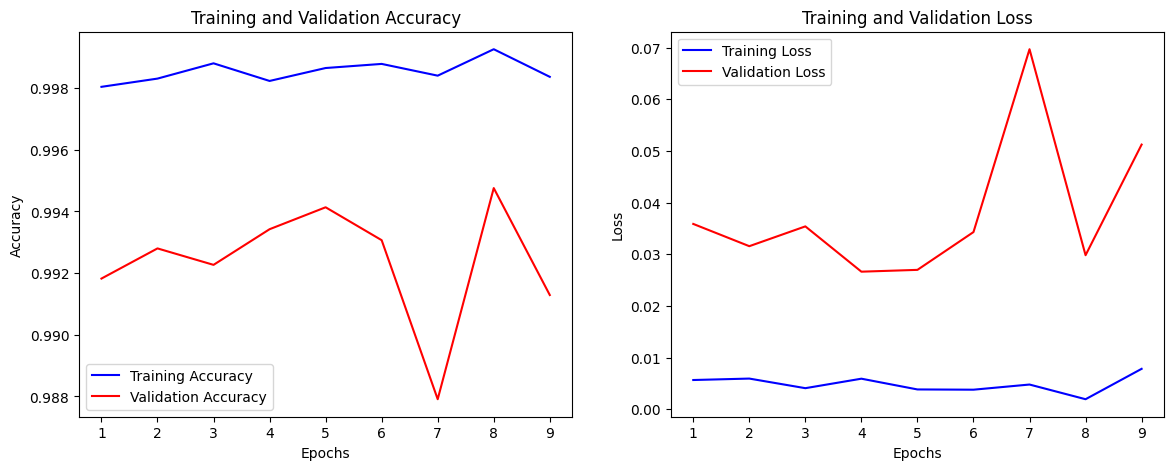

In [12]:
# Store the results
size = {}
size['Model 1'] = {'history': history_1, 'weights': best_model_weights_1}

# Plot results for Model 1
plot_comparison_result(size['Model 1']['history'])

              precision    recall  f1-score   support

     Arborio       1.00      0.98      0.99      2250
     Basmati       0.98      1.00      0.99      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       0.99      0.98      0.99      2250
   Karacadag       0.99      1.00      0.99      2250

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250

Confusion Matrix:
[[2202    1    2   15   30]
 [   0 2240    1    9    0]
 [   0    0 2250    0    0]
 [   0   34    1 2215    0]
 [   5    0    0    0 2245]]


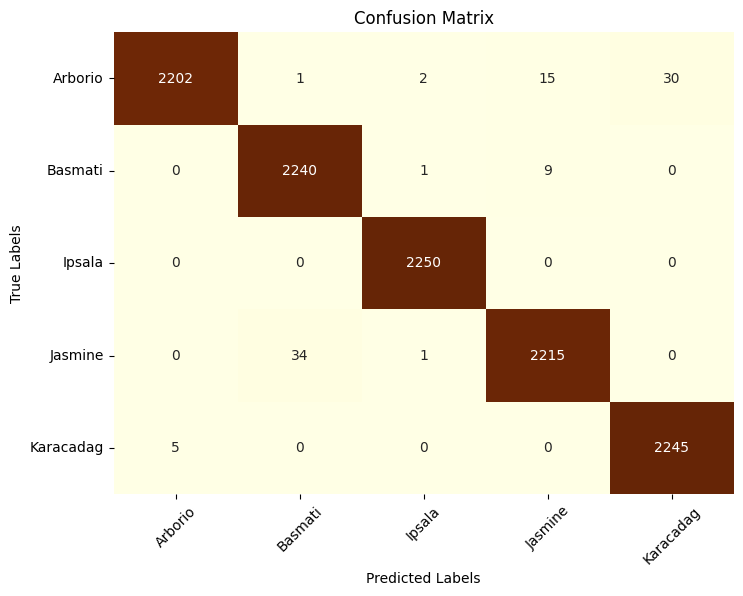

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get true and predicted labels
y_true, y_pred = get_true_and_pred_labels(val_loader, model1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=list(Nam_Rice.keys())))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f'Confusion Matrix:\n{cm}')

# Plot the confusion matrix with yellow color
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrBr", cbar=False, 
            xticklabels=list(Nam_Rice.keys()), 
            yticklabels=list(Nam_Rice.keys()))

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Adjust tick labels
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a better CNN Model with more layers, batch normalization, and dropout
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()

        # First convolutional block: Conv -> BatchNorm -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 5)  

    def forward(self, x):
        # First block: Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model2 = CNNModel2()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

CNNModel2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [15]:
# define a Loss function and optimizer for model_2
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
# train model_2
history_2, best_model_weights_2 = train_model(model2, train_loader, val_loader,
                                        device, loss_fn, optimizer, num_epochs=25, patience=5)

Epoch 1/25, Train Loss: 0.1714, Train Acc: 0.9439
Validation Loss: 0.0381, Validation Acc: 0.9871
Epoch 2/25, Train Loss: 0.0629, Train Acc: 0.9804
Validation Loss: 2.2993, Validation Acc: 0.5490
Epoch 3/25, Train Loss: 0.0460, Train Acc: 0.9850
Validation Loss: 0.1044, Validation Acc: 0.9658
Epoch 4/25, Train Loss: 0.0351, Train Acc: 0.9896
Validation Loss: 0.2420, Validation Acc: 0.8940
Epoch 5/25, Train Loss: 0.0294, Train Acc: 0.9909
Validation Loss: 0.0304, Validation Acc: 0.9884
Epoch 6/25, Train Loss: 0.0258, Train Acc: 0.9921
Validation Loss: 0.0208, Validation Acc: 0.9928
Epoch 7/25, Train Loss: 0.0246, Train Acc: 0.9925
Validation Loss: 0.0268, Validation Acc: 0.9928
Epoch 8/25, Train Loss: 0.0226, Train Acc: 0.9930
Validation Loss: 0.0153, Validation Acc: 0.9948
Epoch 9/25, Train Loss: 0.0229, Train Acc: 0.9934
Validation Loss: 0.0111, Validation Acc: 0.9963
Epoch 10/25, Train Loss: 0.0168, Train Acc: 0.9952
Validation Loss: 0.1551, Validation Acc: 0.9437
Epoch 11/25, Train 

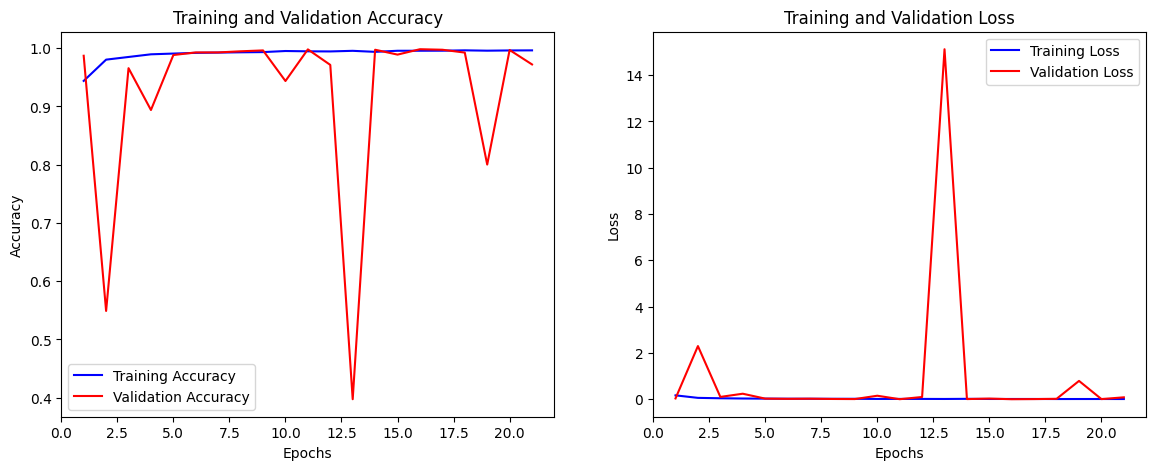

In [16]:
# Initialize dictionary to store results
size = {}
# Store the results for Model 2
size['Model 2'] = {'history': history_2, 'weights': best_model_weights_2}

# Plot results for Model 2
plot_comparison_result(size['Model 2']['history'])

              precision    recall  f1-score   support

     Arborio       1.00      0.98      0.99      2250
     Basmati       0.98      1.00      0.99      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       0.99      0.98      0.99      2250
   Karacadag       0.99      1.00      0.99      2250

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250

Confusion Matrix:
[[2202    1    2   15   30]
 [   0 2240    1    9    0]
 [   0    0 2250    0    0]
 [   0   34    1 2215    0]
 [   5    0    0    0 2245]]


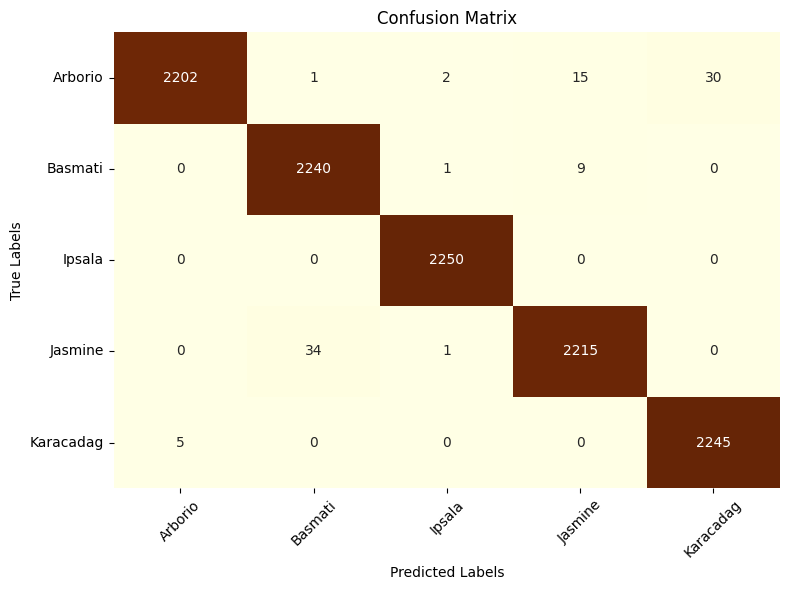

In [17]:
# Get true and predicted labels
y_true, y_pred = get_true_and_pred_labels(val_loader, model1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=list(Nam_Rice.keys())))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f'Confusion Matrix:\n{cm}')

# Plot the confusion matrix with the "YlOrBr" colormap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlOrBr",  # <- Consistent yellow-orange-brown colormap
    cbar=False,
    xticklabels=list(Nam_Rice.keys()),
    yticklabels=list(Nam_Rice.keys())
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [18]:
# Step 2: Load the best weights into model2
model2.load_state_dict(best_model_weights_2)

# Step 3: Assign model2 to model_final as the final model
model_final = model2

# Step 4: Set the model to evaluation mode (for inference or testing)
model_final.eval()

CNNModel2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [19]:
save_path = 'final_model_weights.pth'
# Save the model's state dictionary
torch.save(model_final.state_dict(), save_path)

In [20]:
import torch

# Define the evaluation function
def evaluate(model, test_loader, device, loss_fn):
    model_final.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Calculate loss
            test_loss += loss.item()  # Accumulate loss
            
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions

    # Calculate average loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    return avg_test_loss, test_acc

# Evaluate the final model on the test set
test_loss, test_acc = evaluate(model_final, test_loader, device, loss_fn)


print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.0859, Test Accuracy: 0.9732


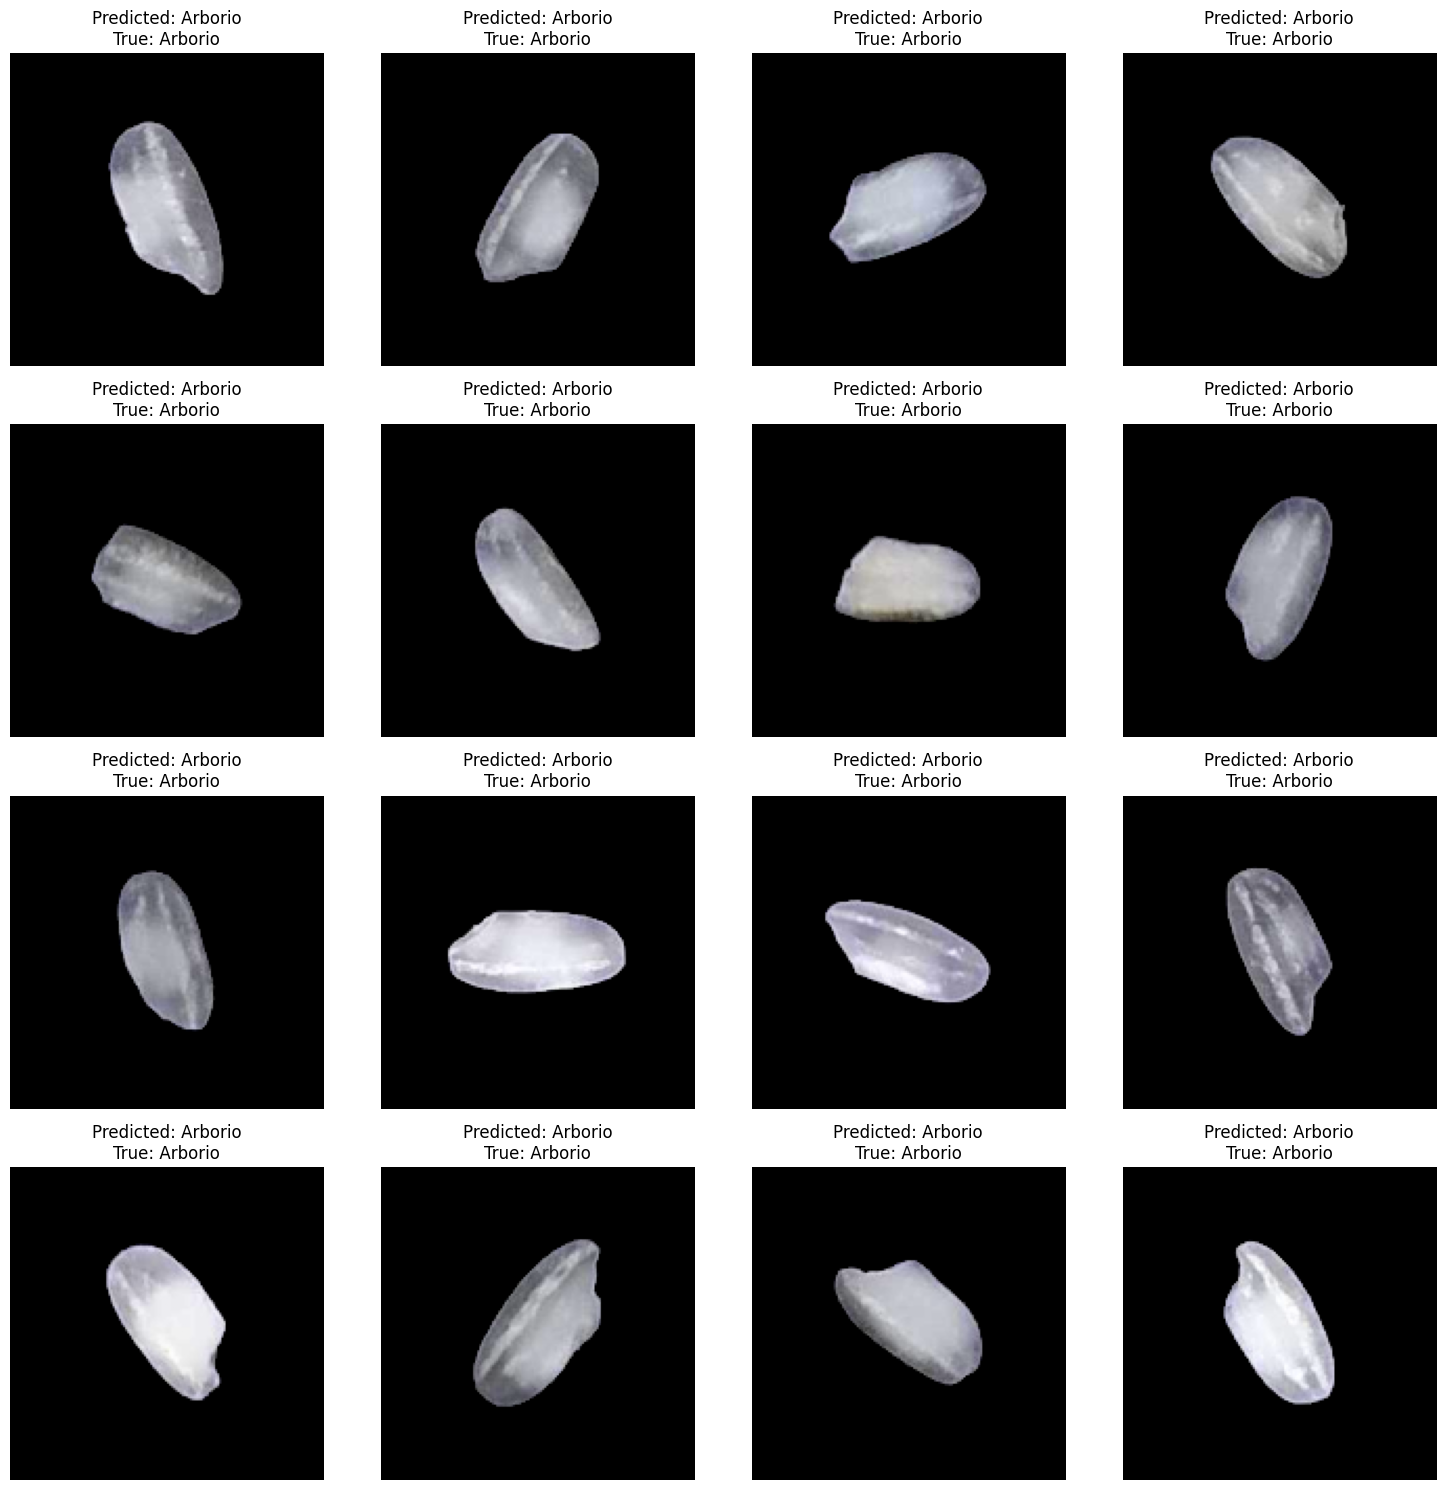

Overall Accuracy: 93.75%


/tmp/ipykernel_19/1230832560.py:46: RuntimeWarning: invalid value encountered in scalar divide
  (pred_labels == i).sum() / (true_labels == i).sum()
/tmp/ipykernel_19/1230832560.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  (pred_labels == i).sum() / (true_labels == i).sum()


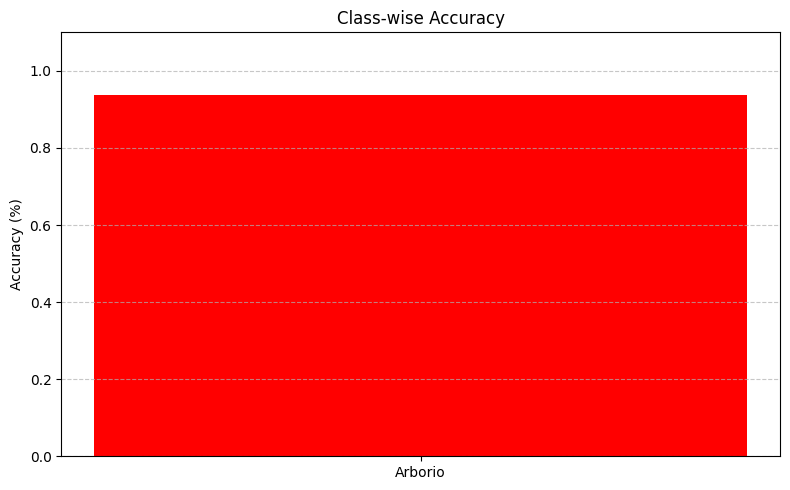

In [21]:
import torch

# Function to plot test images, predicted labels, true labels, and accuracy bar
def plot_predictions(test_images, test_labels, outputs, class_names, device):
    model_final.eval()
    num_images = len(test_images)
    n_rows = 4
    n_cols = 4
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    
    # Plot the images, true labels, and predicted labels
    for i in range(n_rows * n_cols):
        img = test_images[i].to(device)
        img_np = img.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy array for plotting
        
        # Get the predicted label
        with torch.no_grad():
            output = outputs[i]  # Get the ith output prediction
            _, pred = torch.max(output, 0)  # Use dim=0 because the output may have a single dimension
        
        pred_label = pred.item()

        # Get true label
        true_label = test_labels[i].item()
        
        # Plot the image
        ax = axs[i // n_cols, i % n_cols]
        ax.imshow(img_np)
        ax.set_title(f"Predicted: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Convert outputs to predicted labels (argmax over class dimension)
    pred_labels = torch.argmax(outputs, dim=1).cpu().numpy()
    true_labels = test_labels.cpu().numpy()
    
    correct_predictions = np.equal(pred_labels, true_labels)
    accuracy = np.mean(correct_predictions) * 100
    
    print(f"Overall Accuracy: {accuracy:.2f}%")
    
       # Plot the bar chart for class-wise accuracy
    class_accuracy = [
        (pred_labels == i).sum() / (true_labels == i).sum()
        for i in range(len(class_names))
    ]

    plt.figure(figsize=(8, 5))
    plt.bar(class_names, class_accuracy, color='red')  # 🔴 red bars
    plt.title("Class-wise Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 1.1)  # optional: keeps y-axis in 0–100% range
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Usage
test_images, test_labels = next(iter(test_loader))  # Get a batch from test_loader
outputs = model_final(test_images.to(device))  # Get model predictions
plot_predictions(test_images, test_labels, outputs, class_names=["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"], device=device)